In [1]:
import sys
sys.path.append("../")

import os

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
import numpy as np

from models import DenseReparam, DenseWN
from utils import plot_loss
import matplotlib.pyplot as plt

GLOBAL_SEED = 0

os.environ['PYTHONHASHSEED']=str(GLOBAL_SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
dtype = 'float64'
tf.keras.backend.set_floatx(dtype)

train set size: (800, 2) (800, 1)
test set size: (200, 2) (200, 1)


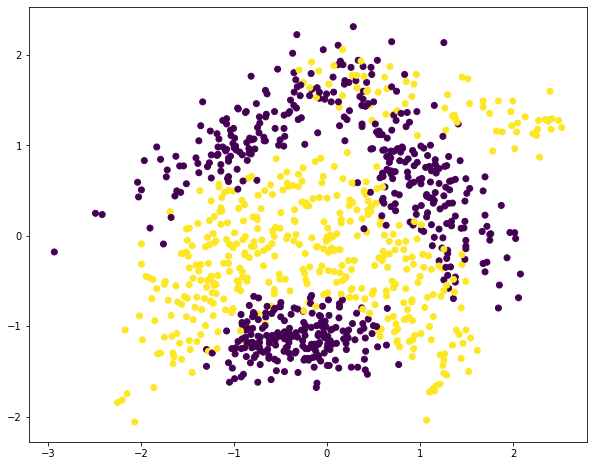

In [2]:
from sklearn.model_selection import train_test_split

banana_dataset = pd.read_csv("banana.csv", sep=",")

x = banana_dataset[['At1','At2']].to_numpy()
y = banana_dataset.Class.to_numpy().reshape(-1, 1)
y[y==-1] = 0
num_data_points = 1000
random_idx = np.random.choice(x.shape[0], size=num_data_points, replace=False) 
x, y = x[random_idx, :], y[random_idx, :]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=GLOBAL_SEED)

train_mean = tf.reduce_mean(x_train, axis=0, keepdims=True)
train_std = tf.math.reduce_std(x_train, axis=0, keepdims=True)
# standardize features
x_train = (x_train - train_mean) / train_std
x_test = (x_test - train_mean) / train_std

print("train set size:", x_train.shape, y_train.shape)
print("test set size:", x_test.shape, y_test.shape)

plt.figure(figsize=(10, 8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)

In [3]:
units = 10
n_epochs = 5000
batch_size = 128
early_stop_patience = 100
lr = 0.1

# Reparam Net

In [4]:
def build_reparam_dnn_model():
    model = keras.Sequential([
        DenseReparam(units, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [5]:
reparam_dnn_model = build_reparam_dnn_model()

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=early_stop_patience//2, verbose=1, mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=early_stop_patience, verbose=1, mode='max', restore_best_weights=True)

In [6]:
reparam_locs_x = [np.zeros(units)]
reparam_locs_y = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    weights = reparam_dnn_model.get_weights()[0]
    thetas = weights[0]
    lambdas = weights[1]

    reparam_locs_x.append(-1.0*lambdas*np.cos(thetas))
    reparam_locs_y.append(-1.0*lambdas*np.sin(thetas))

print_reparam_locs = keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)

In [7]:
history_reparam_dnn = reparam_dnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_reparam_locs, lr_decay, early_stop]
)


Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 115: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model weights from the end of the best epoch: 15.
Epoch 115: early stopping


In [8]:
plot_loss(history_reparam_dnn, ylim=[0, 10], loss_metric_name="CE", plot_validation=True)

In [9]:
train_results_reparam_dnn = reparam_dnn_model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy:", train_results_reparam_dnn[1])
test_results_reparam_dnn = reparam_dnn_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_results_reparam_dnn[1])

Train Accuracy: 0.75875
Test Accuracy: 0.795


In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))

x_grid = np.linspace(-4.5, 4.5, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

pred = reparam_dnn_model(Xplot).numpy().reshape(xx.shape)  # here we only care about the mean

plt.contourf(xx, yy, pred, alpha=0.3)
# plt.colorbar(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cs = plt.contour(xx, yy, pred, [0.5], colors='black', linewidths=3)
plt.plot([0, 0], [0, 0], label='Classification decision boundary', c='black')
# plt.clabel(cs, inline=1, fontsize=10)
# cs.collections[0].set_label("Classification decision boundary")

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x')


weights = reparam_dnn_model.get_weights()[0]
thetas = weights[0]
lambdas = weights[1]
print(weights[2])

feature_locs_x = -1.0*lambdas*np.cos(thetas)
feature_locs_y = -1.0*lambdas*np.sin(thetas)
plt.scatter(feature_locs_x, feature_locs_y, color='red', label="Spetial location of ReLU feature", marker='*',s=200)
# for i in range(units):
#     if i==0:
#         plt.axline([feature_locs_x[i], feature_locs_y[i]], [(feature_locs_x[i]**2+feature_locs_y[i]**2)/feature_locs_x[i], 0], label="Activation boundary of ReLU feature", c="red", linestyle="dashed")
#     else:
#         plt.axline([feature_locs_x[i], feature_locs_y[i]], [(feature_locs_x[i]**2+feature_locs_y[i]**2)/feature_locs_x[i], 0], c="red", linestyle="dashed")

#plt.axis('off')
# plt.xlim(-4, 4)
# plt.ylim(-4, 4)
# plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Test Acc: {0:.3f}".format(test_results_reparam_dnn[1]), fontsize=20)
plt.savefig("banana_natural.pdf", format="pdf", bbox_inches="tight")

[1.27446436 0.56861732 0.71704247 0.86274144 0.26568064 0.17380491
 0.40671694 0.36444902 0.52889552 0.58957823]


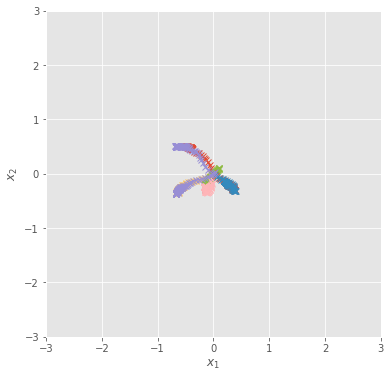

In [11]:
reparam_locs_x_np = np.vstack(reparam_locs_x).T
reparam_locs_y_np = np.vstack(reparam_locs_y).T

plt.figure(figsize=(6, 6))
# plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, alpha=0.5)
# plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x', alpha=0.5)

for i in range(units):
    plt.plot(reparam_locs_x_np[i], reparam_locs_y_np[i], linewidth=1, marker='x')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
# plt.title("Natural Parameterization")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("banana_natural_trajectory_{}.pdf".format(lr), format="pdf", bbox_inches="tight")

In [12]:
reparam_loc_changes = []
for i in range(1, reparam_locs_x_np.shape[-1]):
    reparam_loc_change = np.sqrt((reparam_locs_x_np[:, i] - reparam_locs_x_np[:, i-1])**2 + (reparam_locs_y_np[:, i] - reparam_locs_y_np[:, i-1])**2)
    reparam_loc_changes.append(reparam_loc_change.max())
plt.plot(list(range(1, reparam_locs_x_np.shape[-1])), reparam_loc_changes)
plt.savefig("banana_natural_feature_change_{}.pdf".format(lr), format="pdf", bbox_inches="tight")

# Standard Net

In [13]:
def build_dnn_model():
    model = keras.Sequential([
        keras.layers.Dense(units, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [14]:
dnn_model = build_dnn_model()

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=early_stop_patience//2, verbose=1, mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=early_stop_patience, verbose=1, mode='max', restore_best_weights=True)

In [15]:
dnn_locs_x = [np.zeros(units)]
dnn_locs_y = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    weights = dnn_model.get_weights()
    w = weights[0]
    b = weights[1]
    norm = np.linalg.norm(w, axis=0)

    dnn_locs_x.append(-1.0*b*w[0]/norm**2)
    dnn_locs_y.append(-1.0*b*w[1]/norm**2)

print_dnn_locs = keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)

In [16]:
history_dnn = dnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_dnn_locs, lr_decay, early_stop]
)


Epoch 131: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 181: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model weights from the end of the best epoch: 81.
Epoch 181: early stopping


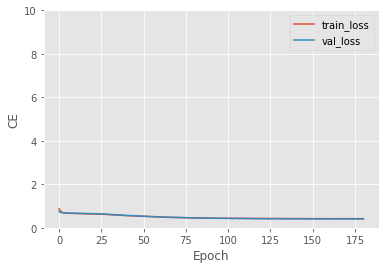

In [17]:
plot_loss(history_dnn, ylim=[0, 10], loss_metric_name="CE", plot_validation=True)

In [18]:
train_results_dnn = dnn_model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy:", train_results_dnn[1])
test_results_dnn = dnn_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_results_dnn[1])

Train Accuracy: 0.805
Test Accuracy: 0.8


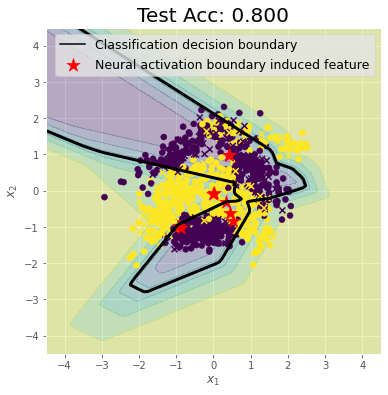

In [19]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))



x_grid = np.linspace(-4.5, 4.5, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

pred = dnn_model(Xplot).numpy().reshape(xx.shape)  # here we only care about the mean

plt.contourf(xx, yy, pred, alpha=0.3)
# plt.colorbar(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cs = plt.contour(xx, yy, pred, [0.5], colors='black', linewidths=3)
plt.plot([0, 0], [0, 0], label='Classification decision boundary', c='black')
# plt.clabel(cs, inline=1, fontsize=10)
# cs.collections[0].set_label("Classification decision boundary")

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x')


weights = dnn_model.get_weights()
w = weights[0]
b = weights[1]
norm = np.linalg.norm(w, axis=0)
feature_locs_x = -1.0*b*w[0]/norm**2
feature_locs_y = -1.0*b*w[1]/norm**2
plt.scatter(feature_locs_x, feature_locs_y, color='red', label="Neural activation boundary induced feature", marker='*',s=200)

plt.title("Test Acc: {0:.3f}".format(test_results_dnn[1]), fontsize=20)
# plt.axis('off')
plt.legend(fontsize=12.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("banana_standard.pdf", format="pdf", bbox_inches="tight")

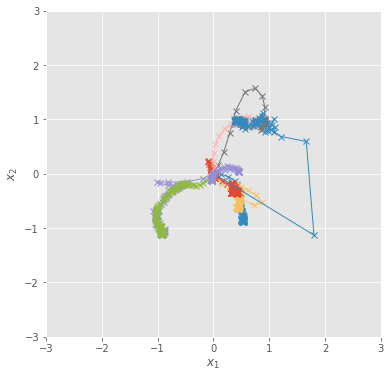

In [20]:
dnn_locs_x_np = np.vstack(dnn_locs_x).T
dnn_locs_y_np = np.vstack(dnn_locs_y).T

plt.figure(figsize=(6, 6))
# plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, alpha=0.5)
# plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x', alpha=0.5)

for i in range(units):
    plt.plot(dnn_locs_x_np[i], dnn_locs_y_np[i], linewidth=1, marker='x')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
# plt.title("Standard Parameterization")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("banana_standard_trajectory_{}.pdf".format(lr), format="pdf", bbox_inches="tight")

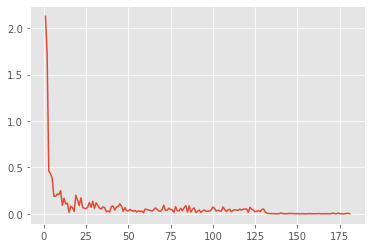

In [21]:
dnn_loc_changes = []
for i in range(1, dnn_locs_x_np.shape[-1]):
    dnn_loc_change = np.sqrt((dnn_locs_x_np[:, i] - dnn_locs_x_np[:, i-1])**2 + (dnn_locs_y_np[:, i] - dnn_locs_y_np[:, i-1])**2)
    dnn_loc_changes.append(dnn_loc_change.max())
plt.plot(list(range(1, dnn_locs_x_np.shape[-1])), dnn_loc_changes)
plt.savefig("banana_standard_feature_change_{}.pdf".format(lr), format="pdf", bbox_inches="tight")

# BatchNorm

In [22]:
def build_bn_dnn_model():
    model = keras.Sequential([
        keras.layers.Dense(units),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [23]:
bn_dnn_model = build_bn_dnn_model()

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=early_stop_patience//2, verbose=1, mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=early_stop_patience, verbose=1, mode='max', restore_best_weights=True)

In [24]:
bn_locs_x = [np.zeros(units)]
bn_locs_y = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    bn_layer = bn_dnn_model.get_layer("batch_normalization")
    mu = bn_layer.moving_mean.numpy()
    sigma = np.sqrt(bn_layer.moving_variance.numpy() + bn_layer.epsilon)
    gamma = bn_layer.gamma.numpy()
    beta = bn_layer.beta.numpy()

    weights = bn_dnn_model.get_weights()
    w = weights[0]
    b = weights[1] + sigma * beta / gamma - mu
    norm = np.linalg.norm(w, axis=0)

    bn_locs_x.append(-1.0*b*w[0]/norm**2)
    bn_locs_y.append(-1.0*b*w[1]/norm**2)

print_bn_locs = keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)

In [25]:
history_bn_dnn = bn_dnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_bn_locs, lr_decay, early_stop]
)


Epoch 160: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 210: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model weights from the end of the best epoch: 110.
Epoch 210: early stopping


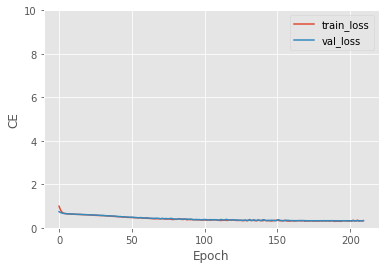

In [26]:
plot_loss(history_bn_dnn, ylim=[0, 10], loss_metric_name="CE", plot_validation=True)

In [27]:
train_results_bn_dnn = bn_dnn_model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy:", train_results_bn_dnn[1])
test_results_bn_dnn = bn_dnn_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_results_bn_dnn[1])

Train Accuracy: 0.88375
Test Accuracy: 0.875


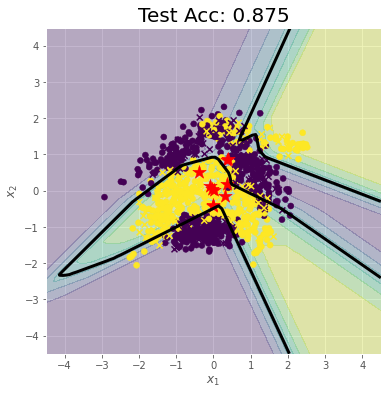

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))



x_grid = np.linspace(-4.5, 4.5, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

pred = bn_dnn_model(Xplot).numpy().reshape(xx.shape)  # here we only care about the mean

plt.contourf(xx, yy, pred, alpha=0.3)
# plt.colorbar(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cs = plt.contour(xx, yy, pred, [0.5], colors='black', linewidths=3)
plt.plot([0, 0], [0, 0], label='Classification decision boundary', c='black')
# plt.clabel(cs, inline=1, fontsize=10)
# cs.collections[0].set_label("Classification decision boundary")

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x')

bn_layer = bn_dnn_model.get_layer("batch_normalization")
mu = bn_layer.moving_mean.numpy()
sigma = np.sqrt(bn_layer.moving_variance.numpy() + bn_layer.epsilon)
gamma = bn_layer.gamma.numpy()
beta = bn_layer.beta.numpy()

weights = bn_dnn_model.get_weights()
w = weights[0]
b = weights[1] + sigma * beta / gamma - mu
norm = np.linalg.norm(w, axis=0)
feature_locs_x = -1.0*b*w[0]/norm**2
feature_locs_y = -1.0*b*w[1]/norm**2
plt.scatter(feature_locs_x, feature_locs_y, color='red', label="Spetial location of ReLU feature", marker='*',s=200)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Test Acc: {0:.3f}".format(test_results_bn_dnn[1]), fontsize=20)
# plt.axis('off')
plt.savefig("banana_batchnorm.pdf", format="pdf", bbox_inches="tight")

In [29]:
bn_locs_x_np = np.vstack(bn_locs_x).T
bn_locs_y_np = np.vstack(bn_locs_y).T

plt.figure(figsize=(6, 6))
# plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, alpha=0.5)
# plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x', alpha=0.5)

for i in range(units):
    plt.plot(bn_locs_x_np[i], bn_locs_y_np[i], linewidth=1, marker='x')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
# plt.title("Batch Normalization")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("banana_batchnorm_trajectory_{}.pdf".format(lr), format="pdf", bbox_inches="tight")

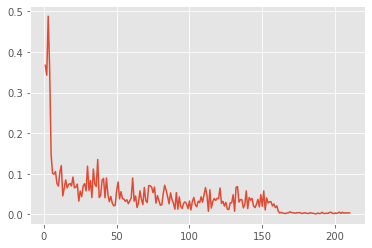

In [30]:
bn_loc_changes = []
for i in range(1, bn_locs_x_np.shape[-1]):
    bn_loc_change = np.sqrt((bn_locs_x_np[:, i] - bn_locs_x_np[:, i-1])**2 + (bn_locs_y_np[:, i] - bn_locs_y_np[:, i-1])**2)
    bn_loc_changes.append(bn_loc_change.max())
plt.plot(list(range(1, bn_locs_x_np.shape[-1])), bn_loc_changes)
plt.savefig("banana_batchnorm_feature_change_{}.pdf".format(lr), format="pdf", bbox_inches="tight")

# weightnorm

In [31]:
def build_wn_dnn_model():
    model = keras.Sequential([
        DenseWN(units, activation='relu'),
        DenseWN(1),
        tf.keras.layers.Activation('sigmoid'),
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(lr), metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [32]:
wn_dnn_model = build_wn_dnn_model()

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=early_stop_patience//2, verbose=1, mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=early_stop_patience, verbose=1, mode='max', restore_best_weights=True)

In [33]:
wn_locs_x = [np.zeros(units)]
wn_locs_y = [np.zeros(units)]

def get_feature_locs(epoch, logs):
    weights = wn_dnn_model.get_weights()
    w = weights[0][:-2, :] / np.linalg.norm(weights[0][:-2, :], axis=0) * weights[0][-1:, :]
    b = weights[1][-2:-1, :]
    norm = np.linalg.norm(w, axis=0)

    wn_locs_x.append(-1.0*b*w[0]/norm**2)
    wn_locs_y.append(-1.0*b*w[1]/norm**2)

print_wn_locs = keras.callbacks.LambdaCallback(on_epoch_end=get_feature_locs)

In [34]:
history_wn_dnn = wn_dnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=0, 
    epochs=n_epochs,
    callbacks=[print_wn_locs, lr_decay, early_stop]
)


Epoch 205: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 255: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model weights from the end of the best epoch: 155.
Epoch 255: early stopping


In [35]:
plot_loss(history_wn_dnn, ylim=[0, 10], loss_metric_name="CE", plot_validation=True)

In [36]:
train_results_wn_dnn = wn_dnn_model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy:", train_results_wn_dnn[1])
test_results_wn_dnn = wn_dnn_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_results_wn_dnn[1])

Train Accuracy: 0.81
Test Accuracy: 0.81


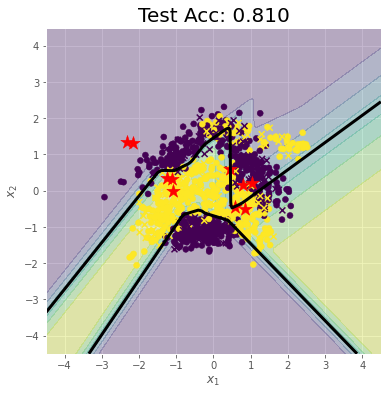

In [37]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))



x_grid = np.linspace(-4.5, 4.5, 100)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

pred = wn_dnn_model(Xplot).numpy().reshape(xx.shape)  # here we only care about the mean

plt.contourf(xx, yy, pred, alpha=0.3)
# plt.colorbar(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cs = plt.contour(xx, yy, pred, [0.5], colors='black', linewidths=3)
plt.plot([0, 0], [0, 0], label='Classification decision boundary', c='black')
# plt.clabel(cs, inline=1, fontsize=10)
# cs.collections[0].set_label("Classification decision boundary")

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x')


weights = wn_dnn_model.get_weights()
w = weights[0][:-2, :] / np.linalg.norm(weights[0][:-2, :], axis=0) * weights[0][-1:, :]
b = weights[1][-2:-1, :]
norm = np.linalg.norm(w, axis=0)
feature_locs_x = -1.0*b*w[0]/norm**2
feature_locs_y = -1.0*b*w[1]/norm**2
plt.scatter(feature_locs_x, feature_locs_y, color='red', label="Spetial location of ReLU feature", marker='*',s=200)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Test Acc: {0:.3f}".format(test_results_wn_dnn[1]), fontsize=20)
# plt.axis('off')
# plt.legend()
plt.savefig("banana_weightnorm.pdf", format="pdf", bbox_inches="tight")

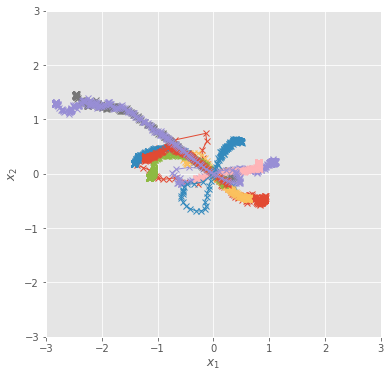

In [38]:
wn_locs_x_np = np.vstack(wn_locs_x).T
wn_locs_y_np = np.vstack(wn_locs_y).T

plt.figure(figsize=(6, 6))
# plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, alpha=0.5)
# plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='x', alpha=0.5)

for i in range(units):
    plt.plot(wn_locs_x_np[i], wn_locs_y_np[i], linewidth=1, marker='x')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
# plt.title("Weight Normalization")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.savefig("banana_weightnorm_trajectory_{}.pdf".format(lr), format="pdf", bbox_inches="tight")

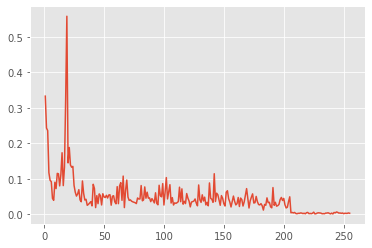

In [39]:
wn_loc_changes = []
for i in range(1, wn_locs_x_np.shape[-1]):
    wn_loc_change = np.sqrt((wn_locs_x_np[:, i] - wn_locs_x_np[:, i-1])**2 + (wn_locs_y_np[:, i] - wn_locs_y_np[:, i-1])**2)
    wn_loc_changes.append(wn_loc_change.max())
plt.plot(list(range(1, wn_locs_x_np.shape[-1])), wn_loc_changes)
plt.savefig("banana_weightnorm_feature_change_{}.pdf".format(lr), format="pdf", bbox_inches="tight")

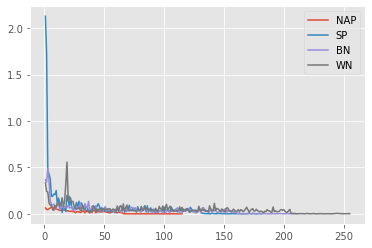

In [40]:
plt.plot(list(range(1, reparam_locs_x_np.shape[-1])), reparam_loc_changes, label="NAP")
plt.plot(list(range(1, dnn_locs_x_np.shape[-1])), dnn_loc_changes, label="SP")
plt.plot(list(range(1, bn_locs_x_np.shape[-1])), bn_loc_changes, label="BN")
plt.plot(list(range(1, wn_locs_x_np.shape[-1])), wn_loc_changes, label="WN")
plt.legend()